# Домашнее задание: дообучение нейросети



Привет!

В этом домашнем задании вам предстоит самим дообучить сеть на новом датасете для классификации.  

В последнем практическом занятии этого модуля мы решали задачу классификации кошек и собак с помощью предобученной на ImageNet сети. На самом деле, это не совсем честно, потому что среди классов ImageNet наверняка есть классы "кошка" и "собака", и сеть, обученная на ImageNet и без дообучения может классифицировать кошек и собак. 
Поэтому в домашнем задании мы возьмем датасет фотографий Intel Image Classification (https://www.kaggle.com/puneet6060/intel-image-classification) природы. 

![alt text](https://miro.medium.com/max/640/1*Y1y83HN7oI98EJT3LQgv-g.png)

## 1. Загрузка датасета


Для загрузки датасета из интернета воспользуемся командами bash. Bash -- язык командной строки linux. В ячейках jupyter notebook можно запускать команды bash, предварительно написав ! в начале ячейки.

In [1]:
# команда ls ИМЯ_ПАПКИ выводит список файлов в указанной папке
! ls seg_train

seg_train


In [2]:
! ls seg_test

seg_test


In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

## Задание 1 (0 баллов)

Как обычно, начнем с загрузки даатсета в пайторч с помощью ImageFolder.

Для начала объявим трансформации.

Объявите трансформации для тренировочного и тестового датасета: 

*   перевод картинки в тензор 
*   нормализация с mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225]


Resize делать не надо! Все картинки этого датасета уже приведены к одному форматц 150*150

In [4]:
transform_train = transforms.Compose([
         transforms.Resize((150, 150)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
         transforms.Resize((150, 150)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

И теперь объявим датасеты:

In [5]:
train_data = datasets.ImageFolder("seg_train", transform=transform_train)
test_data = datasets.ImageFolder("seg_test", transform=transform_val)

In [6]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Объявите даталоадеры. Помните, что для тренировочного даталоадера важно перемешивать данные, для тестового -- неважно. Батч сайз возьмите проивзольный. Но не берите слишком маленький, будете долго ждать обучения сети.

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle = False)

Отлично! Теперь давайте посмотрим на примеры картинок из датасета, и заодно проверим, что вы объявили даталоадеры верно.

In [8]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [9]:
images.shape, labels.shape

(torch.Size([64, 3, 150, 150]), torch.Size([64]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

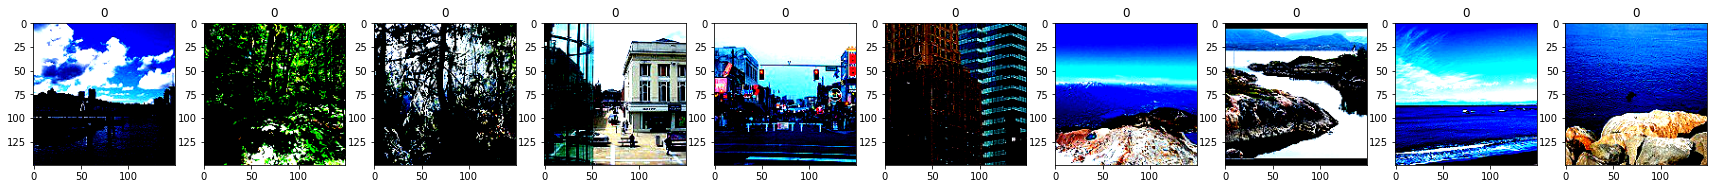

In [10]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


Импортируем нужные модули для обучения сети:

In [11]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

## Задание 2. Обучение сети с нуля. (4 балла код + 1 балл вывод)

Построим сверточную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке.

Так как в этом датасете картинки разрешения 150*150 -- больше, чем разрешение картинок из датасета с практического занятия -- то давайте построим сеть с тремя сверточными слоями и двумя макспуллингами.

In [12]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # объявите слои: Conv-MaxPool-Conv-MaxPool-Conv. 
        # Первый conv слой с 5 ядрами, второй -- с 4, третий -- с 3.
        # MaxPool оба с параметрами (2, 2)

        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)
        self.mp1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(5, 4, kernel_size=4) 
        self.mp2 = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(4, 3, kernel_size=3) 

        # после этого объявите два полносвязных слоя: первый с 256 нейронами, 
        # второй -- с 6 (выходной слой, 6 -- количество классов в датасете)
        # ВАЖНО! вам предстоит узнать, какое количество нейронов будет в первом 
        # полносвязном слое после растягивания карт активации в вектор (Linear(?, 256))
        # проще всего это узнать, запустив обучение сети и посмотрев на текст ошибки:
        # в нем будет указано, сколько нейронов ожидается в линейном слое.
        # P.S. не забудтье Flatten!

        self.flatten = Flatten()
        self.fc1 = nn.Linear(3267, 256)
        self.fc2 = nn.Linear(256, 6)
    
    def forward(self, x):
        # forward pass сети
        # напишите forward pass сети, используйте relu 
        # в качестве промеждуточных активаций и softmax 
        # в качестве активации последнего слоя
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

Тут, как обычно, функция обучения сети:

In [13]:
def train(net, n_epoch=5):
  # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 0.1
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 5 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
          # так получаем текущий батч
            X_batch, y_batch = batch
          
          # обнуляем веса
            optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
            loss.backward()
          # обновление весов сети
            optimizer.step()

          # выведем текущий loss
            running_loss += loss.item()
          # выведем качество каждые 500 батчей
            if i % 10 == 9:
                print('[%d, %5d] loss: %.6f, acc: %3f' %
                    (epoch + 1, i + 1, running_loss / 10, accuracy_score(y_batch.numpy(), np.argmax(y_pred.detach().numpy(), axis=1))))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [14]:
# объявляем сеть
net = ConvNet()
# теперь обучим сеть. Выберите нужное уоличество эпох для обучения. 
# Постарайтесь подобрать его так, чтобы сеть не переобучилась, но и не недообучилась.
# можно поставить побольше эпох и остановить обучение, когда покажется нужным
net = train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[1,    10] loss: 1.791760, acc: 1.000000
[1,    20] loss: 1.791759, acc: 1.000000
[1,    30] loss: 1.791759, acc: 1.000000
[1,    40] loss: 1.791759, acc: 1.000000
[1,    50] loss: 1.791759, acc: 1.000000
[1,    60] loss: 1.791759, acc: 1.000000
[1,    70] loss: 1.791759, acc: 1.000000
[1,    80] loss: 1.791759, acc: 1.000000
[1,    90] loss: 1.791759, acc: 1.000000
[1,   100] loss: 1.791759, acc: 1.000000
[1,   110] loss: 1.791759, acc: 1.000000
[1,   120] loss: 1.791759, acc: 1.000000
[1,   130] loss: 1.791759, acc: 1.000000
[1,   140] loss: 1.791759, acc: 1.000000
[1,   150] loss: 1.791759, acc: 1.000000
[1,   160] loss: 1.791759, acc: 1.000000
[1,   170] loss: 1.791759, acc: 1.000000
[1,   180] loss: 1.791759, acc: 1.000000
[1,   190] loss: 1.791759, acc: 1.000000
[1,   200] loss: 1.791759, acc: 1.000000
[1,   210] loss: 1.791759, acc: 1.000000
[1,   220] loss: 1.791759, acc: 1.000000


  0%|          | 0/220 [00:00<?, ?it/s]

[2,    10] loss: 1.791759, acc: 1.000000
[2,    20] loss: 1.791759, acc: 1.000000
[2,    30] loss: 1.791759, acc: 1.000000
[2,    40] loss: 1.791759, acc: 1.000000
[2,    50] loss: 1.791759, acc: 1.000000
[2,    60] loss: 1.791759, acc: 1.000000
[2,    70] loss: 1.791759, acc: 1.000000
[2,    80] loss: 1.791759, acc: 1.000000
[2,    90] loss: 1.791759, acc: 1.000000
[2,   100] loss: 1.791759, acc: 1.000000
[2,   110] loss: 1.791759, acc: 1.000000
[2,   120] loss: 1.791759, acc: 1.000000
[2,   130] loss: 1.791759, acc: 1.000000
[2,   140] loss: 1.791759, acc: 1.000000
[2,   150] loss: 1.791759, acc: 1.000000
[2,   160] loss: 1.791759, acc: 1.000000
[2,   170] loss: 1.791759, acc: 1.000000
[2,   180] loss: 1.791759, acc: 1.000000
[2,   190] loss: 1.791759, acc: 1.000000
[2,   200] loss: 1.791759, acc: 1.000000
[2,   210] loss: 1.791759, acc: 1.000000
[2,   220] loss: 1.791759, acc: 1.000000


  0%|          | 0/220 [00:00<?, ?it/s]

[3,    10] loss: 1.791759, acc: 1.000000
[3,    20] loss: 1.791759, acc: 1.000000
[3,    30] loss: 1.791759, acc: 1.000000
[3,    40] loss: 1.791759, acc: 1.000000
[3,    50] loss: 1.791759, acc: 1.000000
[3,    60] loss: 1.791759, acc: 1.000000
[3,    70] loss: 1.791759, acc: 1.000000
[3,    80] loss: 1.791759, acc: 1.000000
[3,    90] loss: 1.791759, acc: 1.000000
[3,   100] loss: 1.791759, acc: 1.000000
[3,   110] loss: 1.791759, acc: 1.000000
[3,   120] loss: 1.791759, acc: 1.000000
[3,   130] loss: 1.791759, acc: 1.000000
[3,   140] loss: 1.791759, acc: 1.000000
[3,   150] loss: 1.791759, acc: 1.000000
[3,   160] loss: 1.791759, acc: 1.000000
[3,   170] loss: 1.791759, acc: 1.000000
[3,   180] loss: 1.791759, acc: 1.000000
[3,   190] loss: 1.791759, acc: 1.000000
[3,   200] loss: 1.791759, acc: 1.000000
[3,   210] loss: 1.791759, acc: 1.000000
[3,   220] loss: 1.791759, acc: 1.000000


  0%|          | 0/220 [00:00<?, ?it/s]

[4,    10] loss: 1.791759, acc: 1.000000
[4,    20] loss: 1.791759, acc: 1.000000
[4,    30] loss: 1.791759, acc: 1.000000
[4,    40] loss: 1.791759, acc: 1.000000
[4,    50] loss: 1.791759, acc: 1.000000
[4,    60] loss: 1.791759, acc: 1.000000
[4,    70] loss: 1.791759, acc: 1.000000
[4,    80] loss: 1.791759, acc: 1.000000
[4,    90] loss: 1.791759, acc: 1.000000
[4,   100] loss: 1.791759, acc: 1.000000
[4,   110] loss: 1.791759, acc: 1.000000
[4,   120] loss: 1.791759, acc: 1.000000
[4,   130] loss: 1.791759, acc: 1.000000
[4,   140] loss: 1.791759, acc: 1.000000
[4,   150] loss: 1.791759, acc: 1.000000
[4,   160] loss: 1.791759, acc: 1.000000
[4,   170] loss: 1.791759, acc: 1.000000
[4,   180] loss: 1.791759, acc: 1.000000
[4,   190] loss: 1.791759, acc: 1.000000
[4,   200] loss: 1.791759, acc: 1.000000
[4,   210] loss: 1.791759, acc: 1.000000
[4,   220] loss: 1.791759, acc: 1.000000


  0%|          | 0/220 [00:00<?, ?it/s]

[5,    10] loss: 1.791759, acc: 1.000000
[5,    20] loss: 1.791759, acc: 1.000000
[5,    30] loss: 1.791759, acc: 1.000000
[5,    40] loss: 1.791759, acc: 1.000000
[5,    50] loss: 1.791759, acc: 1.000000
[5,    60] loss: 1.791759, acc: 1.000000
[5,    70] loss: 1.791759, acc: 1.000000
[5,    80] loss: 1.791759, acc: 1.000000
[5,    90] loss: 1.791759, acc: 1.000000
[5,   100] loss: 1.791759, acc: 1.000000
[5,   110] loss: 1.791759, acc: 1.000000
[5,   120] loss: 1.791759, acc: 1.000000
[5,   130] loss: 1.791759, acc: 1.000000
[5,   140] loss: 1.791759, acc: 1.000000
[5,   150] loss: 1.791759, acc: 1.000000
[5,   160] loss: 1.791759, acc: 1.000000
[5,   170] loss: 1.791759, acc: 1.000000
[5,   180] loss: 1.791759, acc: 1.000000
[5,   190] loss: 1.791759, acc: 1.000000
[5,   200] loss: 1.791759, acc: 1.000000
[5,   210] loss: 1.791759, acc: 1.000000
[5,   220] loss: 1.791759, acc: 1.000000
Обучение закончено


Посчитаем accuracy на test:

In [15]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [16]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

1.0

**Задание:** 
Вывод: 

Проанализирейте: переобучилась ли ваша сеть? Достаточно ли хорошо она предсказывает картинки на тесте?

Accuracy неестественно высокая. Есть подозрение на утечку данных.

## Задание 3. Дообучение AlexNet (2+2 балла код + 1 балл вывод)

Теперь давайте попробуем дообучить сеть, предобученную на ImageNet, на нашем датасете.

На практическом занятии мы дообучали Vgg16, теперь даватйе возьмем другую сеть -- AlexNet.

Список сетей, предобученных на ImageNet, которые есть в библиотеке PyTorch: https://pytorch.org/docs/stable/torchvision/models.html

In [17]:
from torchvision import models
AlexNet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/macbook/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
AlexNet.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

**Задание 3.1:**

Напишите класс New_AlexNet на основе AlexNet, у которой заменили последний слой. Заморозьте все слои, кроме слоев классификатора (всех линейных слоев)

In [19]:
class New_AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.AlexNet = AlexNet
        for param in self.AlexNet.features.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, 6)
    
    def forward(self, x):
        x = self.AlexNet(x)
        x = F.softmax(self.fc(x), dim=0)
        return x

In [20]:
net = New_AlexNet()
train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[1,    10] loss: 1.796396, acc: 0.968750
[1,    20] loss: 1.796552, acc: 0.937500
[1,    30] loss: 1.796457, acc: 0.968750
[1,    40] loss: 1.796759, acc: 0.953125
[1,    50] loss: 1.796239, acc: 0.984375
[1,    60] loss: 1.796537, acc: 0.984375
[1,    70] loss: 1.796733, acc: 0.968750
[1,    80] loss: 1.796065, acc: 0.968750
[1,    90] loss: 1.796616, acc: 0.953125
[1,   100] loss: 1.796235, acc: 0.984375
[1,   110] loss: 1.796304, acc: 0.984375
[1,   120] loss: 1.796367, acc: 0.968750
[1,   130] loss: 1.796325, acc: 0.984375
[1,   140] loss: 1.796537, acc: 0.984375
[1,   150] loss: 1.796621, acc: 0.968750
[1,   160] loss: 1.796510, acc: 0.968750
[1,   170] loss: 1.796055, acc: 0.968750
[1,   180] loss: 1.796055, acc: 0.984375
[1,   190] loss: 1.796658, acc: 0.968750
[1,   200] loss: 1.796055, acc: 0.968750
[1,   210] loss: 1.797140, acc: 0.968750
[1,   220] loss: 1.797792, acc: 0.888889


  0%|          | 0/220 [00:00<?, ?it/s]

[2,    10] loss: 1.795896, acc: 0.984375
[2,    20] loss: 1.795885, acc: 0.984375
[2,    30] loss: 1.796325, acc: 0.984375
[2,    40] loss: 1.796065, acc: 0.968750
[2,    50] loss: 1.796235, acc: 0.953125
[2,    60] loss: 1.796235, acc: 0.968750
[2,    70] loss: 1.796065, acc: 0.968750
[2,    80] loss: 1.796065, acc: 0.984375
[2,    90] loss: 1.796160, acc: 0.984375
[2,   100] loss: 1.796208, acc: 0.984375
[2,   110] loss: 1.796315, acc: 0.968750
[2,   120] loss: 1.795986, acc: 0.984375
[2,   130] loss: 1.795975, acc: 0.968750
[2,   140] loss: 1.796764, acc: 0.937500
[2,   150] loss: 1.796065, acc: 0.968750
[2,   160] loss: 1.796405, acc: 0.968750
[2,   170] loss: 1.796669, acc: 0.968750
[2,   180] loss: 1.796325, acc: 0.968750
[2,   190] loss: 1.795986, acc: 0.968750
[2,   200] loss: 1.795896, acc: 0.984375
[2,   210] loss: 1.796669, acc: 0.968750
[2,   220] loss: 1.797231, acc: 0.944444


  0%|          | 0/220 [00:00<?, ?it/s]

[3,    10] loss: 1.796405, acc: 0.968750
[3,    20] loss: 1.796224, acc: 0.984375
[3,    30] loss: 1.796420, acc: 0.953125
[3,    40] loss: 1.796235, acc: 0.968750
[3,    50] loss: 1.795387, acc: 0.984375
[3,    60] loss: 1.796118, acc: 0.953125
[3,    70] loss: 1.796665, acc: 0.968750
[3,    80] loss: 1.796198, acc: 0.984375
[3,    90] loss: 1.796574, acc: 0.968750
[3,   100] loss: 1.796658, acc: 0.953125
[3,   110] loss: 1.796786, acc: 0.953125
[3,   120] loss: 1.795896, acc: 0.953125
[3,   130] loss: 1.796288, acc: 0.984375
[3,   140] loss: 1.797050, acc: 0.953125
[3,   150] loss: 1.795975, acc: 0.968750
[3,   160] loss: 1.796447, acc: 0.984375
[3,   170] loss: 1.796107, acc: 0.968750
[3,   180] loss: 1.795927, acc: 0.968750
[3,   190] loss: 1.796367, acc: 0.968750
[3,   200] loss: 1.796171, acc: 0.984375
[3,   210] loss: 1.796447, acc: 0.968750
[3,   220] loss: 1.797336, acc: 0.888889


  0%|          | 0/220 [00:00<?, ?it/s]

[4,    10] loss: 1.796107, acc: 0.984375
[4,    20] loss: 1.796055, acc: 0.968750
[4,    30] loss: 1.796325, acc: 0.968750
[4,    40] loss: 1.795726, acc: 0.984375
[4,    50] loss: 1.796198, acc: 0.984375
[4,    60] loss: 1.796891, acc: 0.968750
[4,    70] loss: 1.796367, acc: 0.984375
[4,    80] loss: 1.796854, acc: 0.968750
[4,    90] loss: 1.796658, acc: 0.968750
[4,   100] loss: 1.796590, acc: 0.953125
[4,   110] loss: 1.796145, acc: 0.968750
[4,   120] loss: 1.796107, acc: 0.968750
[4,   130] loss: 1.796447, acc: 0.968750
[4,   140] loss: 1.796288, acc: 0.984375
[4,   150] loss: 1.796590, acc: 0.968750
[4,   160] loss: 1.796250, acc: 0.953125
[4,   170] loss: 1.796420, acc: 0.968750
[4,   180] loss: 1.797103, acc: 0.968750
[4,   190] loss: 1.796198, acc: 0.984375
[4,   200] loss: 1.796510, acc: 0.984375
[4,   210] loss: 1.796473, acc: 0.968750
[4,   220] loss: 1.798200, acc: 0.888889


  0%|          | 0/220 [00:00<?, ?it/s]

[5,    10] loss: 1.795715, acc: 0.968750
[5,    20] loss: 1.796499, acc: 0.953125
[5,    30] loss: 1.796748, acc: 0.968750
[5,    40] loss: 1.796250, acc: 0.984375
[5,    50] loss: 1.796627, acc: 0.968750
[5,    60] loss: 1.796537, acc: 0.953125
[5,    70] loss: 1.796537, acc: 0.968750
[5,    80] loss: 1.796288, acc: 0.984375
[5,    90] loss: 1.797035, acc: 0.968750
[5,   100] loss: 1.796330, acc: 0.984375
[5,   110] loss: 1.796235, acc: 0.968750
[5,   120] loss: 1.795986, acc: 0.968750
[5,   130] loss: 1.796250, acc: 0.968750
[5,   140] loss: 1.796288, acc: 0.968750
[5,   150] loss: 1.796224, acc: 0.984375
[5,   160] loss: 1.796187, acc: 0.968750
[5,   170] loss: 1.795986, acc: 0.968750
[5,   180] loss: 1.796616, acc: 0.968750
[5,   190] loss: 1.796405, acc: 0.968750
[5,   200] loss: 1.796748, acc: 0.984375
[5,   210] loss: 1.796409, acc: 0.968750
[5,   220] loss: 1.796669, acc: 0.944444
Обучение закончено


New_AlexNet(
  (AlexNet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

И посмотрим на скор на тесте:

In [21]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [22]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.9996666666666667

**Задание 3.2:**

Напишите класс New_AlexNet на основе AlexNet, у которой заменили последний слой(как в задании выше) Заморозьте все слои, кроме **двух последних** слоев классификатора

In [23]:
class New_AlexNet_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.AlexNet = AlexNet
        for param in self.AlexNet.features.parameters():
            param.requires_grad = False
        for param in list(self.AlexNet.classifier.parameters())[:-2]:
            param.requires_grad = False
        self.fc = nn.Linear(1000, 6)
    
    def forward(self, x):
        x = self.AlexNet(x)
        x = F.softmax(self.fc(x), dim=0)
        return x

In [24]:
net = New_AlexNet_v2()
train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[1,    10] loss: 1.796817, acc: 0.968750
[1,    20] loss: 1.797119, acc: 0.968750
[1,    30] loss: 1.796896, acc: 0.953125
[1,    40] loss: 1.797341, acc: 0.953125
[1,    50] loss: 1.797198, acc: 0.968750
[1,    60] loss: 1.797198, acc: 0.937500
[1,    70] loss: 1.796764, acc: 0.968750
[1,    80] loss: 1.796859, acc: 0.968750
[1,    90] loss: 1.797092, acc: 0.953125
[1,   100] loss: 1.797066, acc: 0.953125
[1,   110] loss: 1.797093, acc: 0.968750
[1,   120] loss: 1.796934, acc: 0.968750
[1,   130] loss: 1.796923, acc: 0.953125
[1,   140] loss: 1.796833, acc: 0.953125
[1,   150] loss: 1.796991, acc: 0.968750
[1,   160] loss: 1.796647, acc: 0.953125
[1,   170] loss: 1.796960, acc: 0.984375
[1,   180] loss: 1.796526, acc: 0.968750
[1,   190] loss: 1.796886, acc: 0.953125
[1,   200] loss: 1.796674, acc: 0.968750
[1,   210] loss: 1.796335, acc: 0.968750
[1,   220] loss: 1.798555, acc: 0.833333


  0%|          | 0/220 [00:00<?, ?it/s]

[2,    10] loss: 1.797013, acc: 0.953125
[2,    20] loss: 1.797066, acc: 0.953125
[2,    30] loss: 1.796531, acc: 0.953125
[2,    40] loss: 1.796934, acc: 0.968750
[2,    50] loss: 1.797171, acc: 0.984375
[2,    60] loss: 1.797093, acc: 0.968750
[2,    70] loss: 1.797892, acc: 0.968750
[2,    80] loss: 1.797447, acc: 0.968750
[2,    90] loss: 1.797262, acc: 0.953125
[2,   100] loss: 1.796881, acc: 0.968750
[2,   110] loss: 1.797066, acc: 0.953125
[2,   120] loss: 1.797108, acc: 0.968750
[2,   130] loss: 1.796727, acc: 0.953125
[2,   140] loss: 1.796674, acc: 0.984375
[2,   150] loss: 1.796467, acc: 0.968750
[2,   160] loss: 1.797070, acc: 0.968750
[2,   170] loss: 1.796504, acc: 0.984375
[2,   180] loss: 1.797527, acc: 0.968750
[2,   190] loss: 1.796949, acc: 0.968750
[2,   200] loss: 1.796934, acc: 0.984375
[2,   210] loss: 1.796632, acc: 0.968750
[2,   220] loss: 1.798015, acc: 0.888889


  0%|          | 0/220 [00:00<?, ?it/s]

[3,    10] loss: 1.796754, acc: 0.953125
[3,    20] loss: 1.796621, acc: 0.968750
[3,    30] loss: 1.796896, acc: 0.968750
[3,    40] loss: 1.797093, acc: 0.953125
[3,    50] loss: 1.796859, acc: 0.953125
[3,    60] loss: 1.797183, acc: 0.953125
[3,    70] loss: 1.797357, acc: 0.953125
[3,    80] loss: 1.796806, acc: 0.968750
[3,    90] loss: 1.797410, acc: 0.937500
[3,   100] loss: 1.796896, acc: 0.968750
[3,   110] loss: 1.796806, acc: 0.968750
[3,   120] loss: 1.797278, acc: 0.953125
[3,   130] loss: 1.797225, acc: 0.968750
[3,   140] loss: 1.796293, acc: 0.968750
[3,   150] loss: 1.797055, acc: 0.968750
[3,   160] loss: 1.797145, acc: 0.953125
[3,   170] loss: 1.797013, acc: 0.953125
[3,   180] loss: 1.796844, acc: 0.968750
[3,   190] loss: 1.797485, acc: 0.953125
[3,   200] loss: 1.796896, acc: 0.953125
[3,   210] loss: 1.796187, acc: 0.984375
[3,   220] loss: 1.797759, acc: 0.888889


  0%|          | 0/220 [00:00<?, ?it/s]

[4,    10] loss: 1.797183, acc: 0.968750
[4,    20] loss: 1.796452, acc: 0.968750
[4,    30] loss: 1.797093, acc: 0.968750
[4,    40] loss: 1.796632, acc: 0.968750
[4,    50] loss: 1.796541, acc: 0.953125
[4,    60] loss: 1.797198, acc: 0.953125
[4,    70] loss: 1.796886, acc: 0.953125
[4,    80] loss: 1.797003, acc: 0.953125
[4,    90] loss: 1.797632, acc: 0.953125
[4,   100] loss: 1.797066, acc: 0.968750
[4,   110] loss: 1.797156, acc: 0.953125
[4,   120] loss: 1.797252, acc: 0.953125
[4,   130] loss: 1.797315, acc: 0.968750
[4,   140] loss: 1.797527, acc: 0.937500
[4,   150] loss: 1.796584, acc: 0.968750
[4,   160] loss: 1.796584, acc: 0.968750
[4,   170] loss: 1.796844, acc: 0.953125
[4,   180] loss: 1.797225, acc: 0.937500
[4,   190] loss: 1.797183, acc: 0.984375
[4,   200] loss: 1.797198, acc: 0.953125
[4,   210] loss: 1.796764, acc: 0.968750
[4,   220] loss: 1.798282, acc: 0.833333


  0%|          | 0/220 [00:00<?, ?it/s]

[5,    10] loss: 1.796568, acc: 0.968750
[5,    20] loss: 1.797002, acc: 0.953125
[5,    30] loss: 1.797051, acc: 0.968750
[5,    40] loss: 1.796647, acc: 0.953125
[5,    50] loss: 1.797039, acc: 0.968750
[5,    60] loss: 1.796504, acc: 0.968750
[5,    70] loss: 1.797108, acc: 0.953125
[5,    80] loss: 1.797066, acc: 0.953125
[5,    90] loss: 1.797130, acc: 0.953125
[5,   100] loss: 1.797500, acc: 0.968750
[5,   110] loss: 1.796425, acc: 0.968750
[5,   120] loss: 1.796764, acc: 0.953125
[5,   130] loss: 1.797003, acc: 0.968750
[5,   140] loss: 1.797066, acc: 0.968750
[5,   150] loss: 1.797511, acc: 0.953125
[5,   160] loss: 1.797029, acc: 0.984375
[5,   170] loss: 1.797145, acc: 0.953125
[5,   180] loss: 1.796764, acc: 0.984375
[5,   190] loss: 1.796674, acc: 0.984375
[5,   200] loss: 1.797278, acc: 0.953125
[5,   210] loss: 1.797606, acc: 0.937500
[5,   220] loss: 1.798841, acc: 0.833333
Обучение закончено


New_AlexNet_v2(
  (AlexNet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)


И посмотрим на скор на тесте:

In [25]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [26]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.9993333333333333

**Задание 3.3:** Вывод:

Какие результаты у вас получились? Классифицирует ли картинки природы лучше сеть, предобученная на ImageNet, или ваша сеть из задания два получилась лучше? 
Есть ли разница между дообучением двух последних слоев сети или всех линейных слоев сети?

 **Тут напишите ваш вывод**

Больше всего score получился у "своей" сети из задания (скорее всего, она настроилась на утечку). У предобученной сети score ниже, причем ниже всего у той, в которой дообучались только два последних слоя (слои, предобученные на данных, не содержащих эту утечку, мешают её использовать).